In [2]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback
import xgboost as xgb
from xgboost import XGBClassifier

In [9]:
# Load the dataset
data = pd.read_csv(Path('Training_Fraudulent_E-Commerce_Transaction_Data_2.csv'))

# Review the DataFrame
print(data.nunique())
data.head()


Transaction ID        23634
Customer ID           23634
Transaction Amount    18375
Transaction Date      23607
Payment Method            4
Product Category          5
Quantity                  5
Customer Age             74
Customer Location     14868
Device Used               3
IP Address            23634
Shipping Address      23634
Billing Address       23634
Is Fraudulent             2
Account Age Days        365
Transaction Hour         24
dtype: int64


,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,8ca9f102-02a4-4207-ab63-484e83a1bdf0,42.32,2024-03-24 23:42:43,PayPal,electronics,1,40,East Jameshaven,desktop,110.87.246.85,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,0,282,23
1,7d187603-7961-4fce-9827-9698e2b6a201,4d158416-caae-4b09-bd5b-15235deb9129,301.34,2024-01-22 00:53:31,credit card,electronics,3,35,Kingstad,tablet,14.73.104.153,"5230 Stephanie Forge\nCollinsbury, PR 81853","5230 Stephanie Forge\nCollinsbury, PR 81853",0,223,0
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,ccae47b8-75c7-4f5a-aa9e-957deced2137,340.32,2024-01-22 08:06:03,debit card,toys & games,5,29,North Ryan,desktop,67.58.94.93,"195 Cole Oval\nPort Larry, IA 58422","4772 David Stravenue Apt. 447\nVelasquezside, ...",0,360,8
3,e9949bfa-194d-486b-84da-9565fca9e5ce,b04960c0-aeee-4907-b1cd-4819016adcef,95.77,2024-01-16 20:34:53,credit card,electronics,5,45,Kaylaville,mobile,202.122.126.216,"7609 Cynthia Square\nWest Brenda, NV 23016","7609 Cynthia Square\nWest Brenda, NV 23016",0,325,20
4,7362837c-7538-434e-8731-0df713f5f26d,de9d6351-b3a7-4bc7-9a55-8f013eb66928,77.45,2024-01-16 15:47:23,credit card,clothing,5,42,North Edwardborough,desktop,96.77.232.76,"2494 Robert Ramp Suite 313\nRobinsonport, AS 5...","2494 Robert Ramp Suite 313\nRobinsonport, AS 5...",0,116,15


In [10]:
# Display dataset structure
print(data.info())

# View the first few rows
print(data.head())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction ID      23634 non-null  object 
 1   Customer ID         23634 non-null  object 
 2   Transaction Amount  23634 non-null  float64
 3   Transaction Date    23634 non-null  object 
 4   Payment Method      23634 non-null  object 
 5   Product Category    23634 non-null  object 
 6   Quantity            23634 non-null  int64  
 7   Customer Age        23634 non-null  int64  
 8   Customer Location   23634 non-null  object 
 9   Device Used         23634 non-null  object 
 10  IP Address          23634 non-null  object 
 11  Shipping Address    23634 non-null  object 
 12  Billing Address     23634 non-null  object 
 13  Is Fraudulent       23634 non-null  int64  
 14  Account Age Days    23634 non-null  int64  
 15  Transaction Hour    23634 non-null  int64  
dtypes: f

In [11]:
# Drop irrelevant columns
data_cleaned = data.drop(columns=['Transaction ID', 'Customer ID', 'IP Address', 'Shipping Address', 'Billing Address'])
data_cleaned


# Convert 'Transaction Date' to datetime and extract features
data_cleaned['Transaction Date'] = pd.to_datetime(data_cleaned['Transaction Date'])
data_cleaned['Year'] = data_cleaned['Transaction Date'].dt.year
data_cleaned['Month'] = data_cleaned['Transaction Date'].dt.month
data_cleaned['Day'] = data_cleaned['Transaction Date'].dt.day
data_cleaned['Hour'] = data_cleaned['Transaction Date'].dt.hour
data_cleaned = data_cleaned.drop(columns=['Transaction Date'])


data_cleaned = pd.get_dummies(data_cleaned, columns=['Payment Method', 'Product Category', 'Device Used'], drop_first=True)
data_cleaned



,Transaction Amount,Quantity,Customer Age,Customer Location,Is Fraudulent,Account Age Days,Transaction Hour,Year,Month,Day,Hour,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_mobile,Device Used_tablet
0,42.32,1,40,East Jameshaven,0,282,23,2024,3,24,23,False,False,False,True,False,False,False,False,False
1,301.34,3,35,Kingstad,0,223,0,2024,1,22,0,False,True,False,True,False,False,False,False,True
2,340.32,5,29,North Ryan,0,360,8,2024,1,22,8,False,False,True,False,False,False,True,False,False
3,95.77,5,45,Kaylaville,0,325,20,2024,1,16,20,False,True,False,True,False,False,False,True,False
4,77.45,5,42,North Edwardborough,0,116,15,2024,1,16,15,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23629,53.73,5,32,Rebeccafurt,0,363,16,2024,1,26,16,False,False,False,False,False,False,True,False,True
23630,47.42,4,41,Nataliefort,0,296,17,2024,2,25,17,False,True,False,False,False,False,False,False,False
23631,1045.23,1,9,East Shannonville,0,329,23,2024,3,28,23,True,False,False,False,True,False,False,False,True
23632,34.25,2,39,Lake Nicole,0,347,11,2024,2,9,11,False,False,True,False,False,True,False,True,False


In [12]:
# Define features and target
X = data_cleaned.drop(columns=['Is Fraudulent'])
y = data_cleaned['Is Fraudulent']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (23634, 19)
Target shape: (23634,)


In [13]:
X

,Transaction Amount,Quantity,Customer Age,Customer Location,Account Age Days,Transaction Hour,Year,Month,Day,Hour,Payment Method_bank transfer,Payment Method_credit card,Payment Method_debit card,Product Category_electronics,Product Category_health & beauty,Product Category_home & garden,Product Category_toys & games,Device Used_mobile,Device Used_tablet
0,42.32,1,40,East Jameshaven,282,23,2024,3,24,23,False,False,False,True,False,False,False,False,False
1,301.34,3,35,Kingstad,223,0,2024,1,22,0,False,True,False,True,False,False,False,False,True
2,340.32,5,29,North Ryan,360,8,2024,1,22,8,False,False,True,False,False,False,True,False,False
3,95.77,5,45,Kaylaville,325,20,2024,1,16,20,False,True,False,True,False,False,False,True,False
4,77.45,5,42,North Edwardborough,116,15,2024,1,16,15,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23629,53.73,5,32,Rebeccafurt,363,16,2024,1,26,16,False,False,False,False,False,False,True,False,True
23630,47.42,4,41,Nataliefort,296,17,2024,2,25,17,False,True,False,False,False,False,False,False,False
23631,1045.23,1,9,East Shannonville,329,23,2024,3,28,23,True,False,False,False,True,False,False,False,True
23632,34.25,2,39,Lake Nicole,347,11,2024,2,9,11,False,False,True,False,False,True,False,True,False


In [14]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
X_train, X_test, y_train, y_test

(       Transaction Amount  Quantity  Customer Age  Customer Location  \
 9446               294.72         5            19        Melindafurt   
 14163              371.32         4            39        East Jeremy   
 7619                50.27         3            21       North Brandi   
 22974              283.50         5            30        Phillipside   
 21205               53.65         1            37    West Steveville   
 ...                   ...       ...           ...                ...   
 14815               76.42         5            23  New Christinaland   
 9897               395.55         1            31       Franklinland   
 493                104.36         4            61        Lake Robert   
 10041               43.74         2            14      Lake Jacktown   
 117                150.43         4            39          Jasonport   
 
        Account Age Days  Transaction Hour  Year  Month  Day  Hour  \
 9446                 91                 6  2024    

In [15]:
print("Customer Location" in X_train.columns)

True


In [16]:
X_train = X_train.drop(columns=['Customer Location'])
X_test = X_test.drop(columns=['Customer Location'])


In [17]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Initialize and Train the XGBoost Model
model = XGBClassifier(
    n_estimators=200, 
    max_depth=5, 
    scale_pos_weight=5,
    random_state=42
)
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [19]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [20]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4421   62]
 [ 131  113]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4483
           1       0.65      0.46      0.54       244

    accuracy                           0.96      4727
   macro avg       0.81      0.72      0.76      4727
weighted avg       0.95      0.96      0.96      4727



In [21]:
# Reinitialize and Train the XGBoost Model
model = XGBClassifier(
    n_estimators=200, 
    max_depth=5, 
    scale_pos_weight=10,
    random_state=42
)
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [22]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [23]:
# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4394   89]
 [ 126  118]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      4483
           1       0.57      0.48      0.52       244

    accuracy                           0.95      4727
   macro avg       0.77      0.73      0.75      4727
weighted avg       0.95      0.95      0.95      4727



In [24]:
# Convert the data into DMatrix, optimized for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Specify parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 5,
    'scale_pos_weight': 10,
    'random_state': 42
}

# Define evaluation set
eval_set = [(dtrain, 'train'), (dtest, 'test')]

# Train the model with early stopping
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=eval_set,
    early_stopping_rounds=10,
    verbose_eval=True
)

# Make predictions
y_pred_proba = bst.predict(dtest)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[0]	train-logloss:0.39609	test-logloss:0.39827
[1]	train-logloss:0.34925	test-logloss:0.35389
[2]	train-logloss:0.31848	test-logloss:0.32516
[3]	train-logloss:0.29761	test-logloss:0.30614
[4]	train-logloss:0.28368	test-logloss:0.29333
[5]	train-logloss:0.27359	test-logloss:0.28422
[6]	train-logloss:0.26668	test-logloss:0.27862
[7]	train-logloss:0.26078	test-logloss:0.27382
[8]	train-logloss:0.25750	test-logloss:0.27173
[9]	train-logloss:0.25316	test-logloss:0.27000
[10]	train-logloss:0.24901	test-logloss:0.26623
[11]	train-logloss:0.24657	test-logloss:0.26485
[12]	train-logloss:0.24449	test-logloss:0.26375
[13]	train-logloss:0.24084	test-logloss:0.26115
[14]	train-logloss:0.23881	test-logloss:0.26025
[15]	train-logloss:0.23279	test-logloss:0.25525
[16]	train-logloss:0.23052	test-logloss:0.25395
[17]	train-logloss:0.22720	test-logloss:0.25170
[18]	train-logloss:0.22447	test-logloss:0.24980
[19]	train-logloss:0.22214	test-logloss:0.24866
[20]	train-logloss:0.21975	test-logloss:0.24710
[2

In [25]:
# Save the trained model to a file
bst.save_model("Accuracy model xgboost.json")

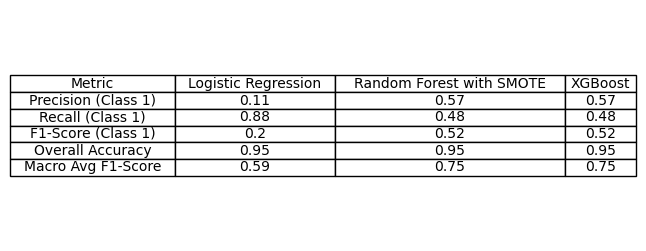

In [3]:
# Random Forest w/SMOTE model Compared to XGBoost model
data = {
    "Metric": ["Precision (Class 1)", "Recall (Class 1)", "F1-Score (Class 1)", "Overall Accuracy", "Macro Avg F1-Score"],
    "Logistic Regression": [0.11, 0.88, 0.20, 0.95, 0.59],
    "Random Forest with SMOTE": [0.57, 0.48, 0.52, 0.95, 0.75],
    "XGBoost": [0.57, 0.48, 0.52, 0.95, 0.75]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plot the table
fig, ax = plt.subplots(figsize=(4, 3))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Save the table as an image
plt.savefig("performance_comparison.png", bbox_inches='tight', dpi=300)

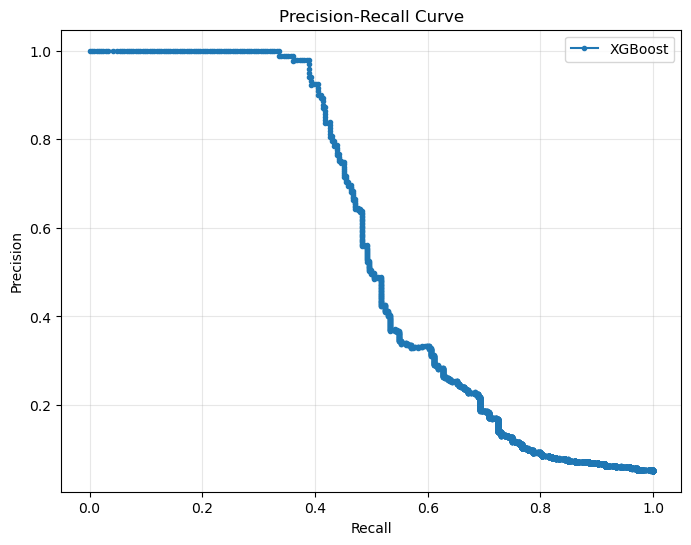

In [27]:
# Precision-Recall Curve
# Generate precision and recall values
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label="XGBoost")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

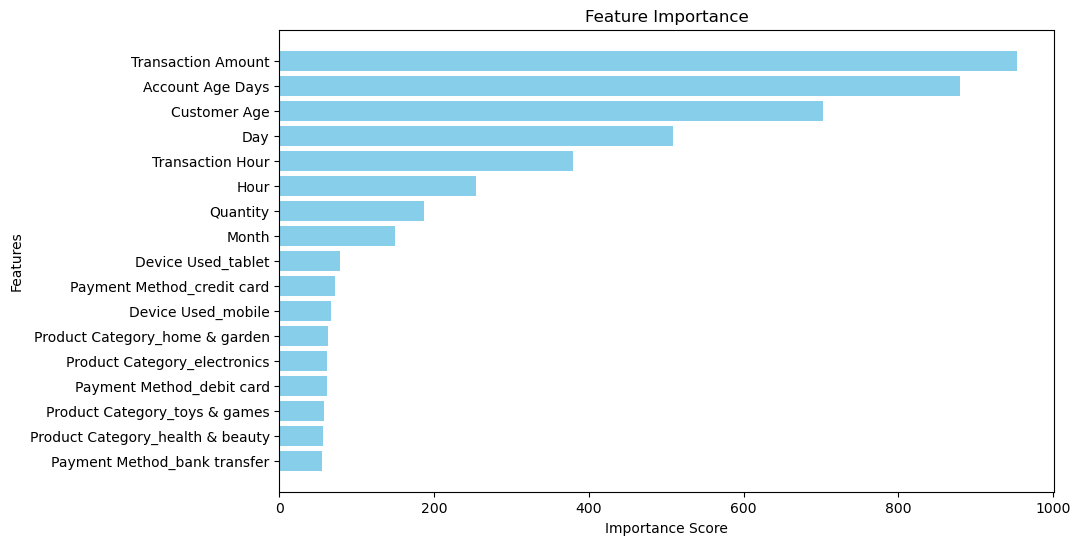

In [29]:
# Feature Importance Plot
# Retrieve feature names
feature_names = X_train.columns

# Get feature importance
feature_importance = model.get_booster().get_score(importance_type='weight')

# Map feature names
mapped_feature_importance = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Sort and plot
sorted_importance = sorted(mapped_feature_importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, scores, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

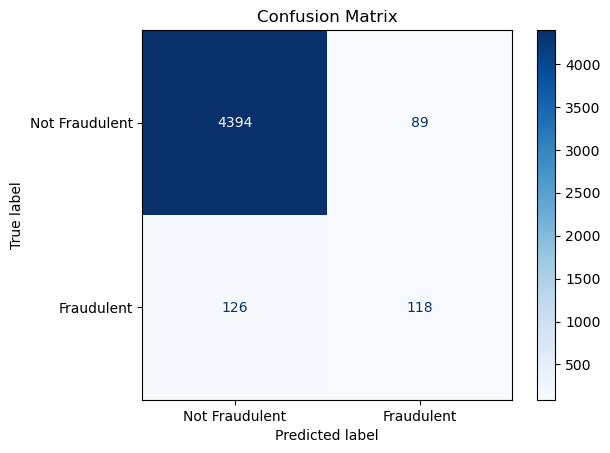

In [31]:
# Confusion Matrix Heatmap
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraudulent", "Fraudulent"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

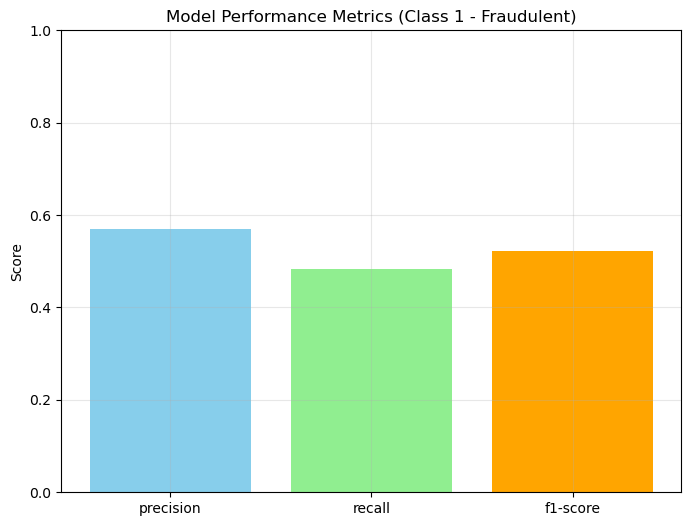

In [32]:
# Classification Report Visualization
# Get classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract metrics for "Class 1" (Fraudulent)
metrics = ["precision", "recall", "f1-score"]
values = [report["1"][metric] for metric in metrics]

# Plot the metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=["skyblue", "lightgreen", "orange"])
plt.title("Model Performance Metrics (Class 1 - Fraudulent)")
plt.ylabel("Score")
plt.ylim(0, 1)  # Scores range between 0 and 1
plt.grid(alpha=0.3)
plt.show()